# BioPhysical parameters with Sentinel Toolbox Python bindings
## Disclaimer
** This notebook is a technology demonstration, none of the results are validated! **
This notebook shows how the 'snappy' Python module from the Sentinel toolbox. It can be tested inside the PROBA-V MEP notebook environment: https://proba-v-mep.esa.int/notebooks.
## Goal
The goal of this notebook is to compute BioPhysical parameters using Sentinel 2 reflectance data. The input reflectance data has already been radiometrically and geometrically corrected, and can be found on the exploitation platform.
This scenario is mainly used as a way to demonstrate how snappy can be used and configured inside a notebook, and how it integrates with Python libraries.
## Known Limitations
Angle information is not taken into account when computing biophysical parameters. 

## 1. Basic snappy configuration
Before importing snappy, we write a config file into the working directory. Snappy start a Java program in the background, and this config file allows us to modify some basic settings of this program, such as amount of available memory.

In [1]:
snappy_ini = """
[DEFAULT]
snap_home = /usr/local/snap
# java_class_path: ./target/classes
# java_library_path: ./lib
# java_options: -Djava.awt.headless=false
java_max_mem: 3G
debug: True
"""
with open("snappy.ini", "w") as conf_file:
    conf_file.write(snappy_ini)

## 2. Load snappy
We now import snappy and check some basic settings.
The userDir is important, as Snappy will use it to write various files. We check the location of this directory and it's current contents.

In [2]:
import snappy
from snappy import ProductUtils,ProductData
config = snappy.EngineConfig.instance()
print(config.userDir())
print(snappy.EngineConfig.instance().storagePath())
!ls -l /tmp/snap/auxdata/
userdir = snappy.EngineConfig.instance().userDir()
userdir.toUri().toString()

/opt/rh/python27/root/usr/lib64/python2.7/site-packages/snappy: java_module_dirs = 
['/usr/local/snap/s1tbx/modules',
 '/usr/local/snap/s2tbx/modules',
 '/usr/local/snap/s3tbx/modules',
 '/usr/local/snap/rstb/modules',
 '/usr/local/snap/probavbox/modules',
 '/usr/local/snap/snap/modules']
/opt/rh/python27/root/usr/lib64/python2.7/site-packages/snappy: env =
(['/usr/local/snap/s1tbx/modules/org-esa-s1tbx-s1tbx-kit.jar',
  '/usr/local/snap/s1tbx/modules/org-esa-s1tbx-s1tbx-op-insar.jar',
  '/usr/local/snap/s1tbx/modules/org-esa-s1tbx-s1tbx-op-sar-processing.jar',
  '/usr/local/snap/s1tbx/modules/org-esa-s1tbx-s1tbx-op-sentinel1.jar',
  '/usr/local/snap/s1tbx/modules/ext/org.esa.s1tbx.s1tbx-io/org-apache-commons/commons-math3.jar',
  '/usr/local/snap/s1tbx/modules/ext/org.esa.s1tbx.s1tbx-io/org-jsoup/jsoup.jar',
  '/usr/local/snap/s1tbx/modules/ext/org.jlinda.jlinda-nest/org-jblas/jblas.jar',
  '/usr/local/snap/s1tbx/modules/ext/org.esa.s1tbx.s1tbx-op-utilities/edu-emory-mathcs/jtransform

'file:///tmp/snap/'

### Load auxiliary data for Biophysical algorithm
The algorithm that we will use should normally write some data to the user dir. If this does not happen automatically, we can trigger it manually as shown below.

In [4]:
activator = snappy.jpy.get_type('org.esa.s2tbx.biophysical.BiophysicalActivator')
activator().start()

## 3. Find input data
On the exploitation platform, a catalog client is available to find input data, we use this to find the filename of a radiometry product.

In [5]:
from catalogclient import catalog
cat=catalog.Catalog()


In [6]:
import datetime
date = datetime.date(2017, 7, 18)
products = cat.get_products('CGS_S2_RADIOMETRY', 
                            fileformat='GEOTIFF', 
                            startdate=date, 
                            enddate=date)

In [7]:
p = products[0]
f = p.files[0]
print(f.bands)
print(f.filename)
path = f.filename[5:]

[u'B02']
file:/data/MTDA/CGS_S2_RADIOMETRY/2017/07/18/S2A_20170718T110452Z_31UER_TOC_V100/S2A_20170718T110452Z_31UER_TOC-B02_10M_V100.tif


## 4. Combine separate bands into a Sentinel 2 product
The algorithm that we want to use expects a product with specific metadata and bands. The products available on the platform are provided as individual tiff images. 
As a workaround, we load all images individually and combine them into a single product. I ensure that the layout of the product conforms to what the algorithm expects. Doing this required some trial and error, and inspection of the source code of the algorithm:
https://github.com/senbox-org/s2tbx/blob/6.x/s2tbx-biophysical/src/main/java/org/esa/s2tbx/biophysical/BiophysicalOp.java


In [8]:
S2BandConstant = snappy.jpy.get_type('org.esa.s2tbx.biophysical.BiophysicalOp$S2BandConstant')
def getProduct(filename, bandconstant):
    inputProduct = snappy.ProductIO.readProduct(filename.replace("B02", bandconstant.getFilenameBandId()))
    inputProduct.getBandAt(0).setSpectralWavelength(bandconstant.getWavelengthCentral())
    inputProduct.getBandAt(0).setName(bandconstant.getPhysicalName())
    return inputProduct

file20M = path.replace("10M","20M")

b3Product = getProduct(path, S2BandConstant.B3)
ProductUtils.copyBand(S2BandConstant.B4.getPhysicalName(),getProduct(path,S2BandConstant.B4),b3Product,True)
ProductUtils.copyBand(S2BandConstant.B5.getPhysicalName(),getProduct(file20M,S2BandConstant.B5),b3Product,True)
ProductUtils.copyBand(S2BandConstant.B6.getPhysicalName(),getProduct(file20M,S2BandConstant.B6),b3Product,True)
ProductUtils.copyBand(S2BandConstant.B7.getPhysicalName(),getProduct(file20M,S2BandConstant.B7),b3Product,True)
ProductUtils.copyBand(S2BandConstant.B8A.getPhysicalName(),getProduct(file20M,S2BandConstant.B8A),b3Product,True)
ProductUtils.copyBand(S2BandConstant.B11.getPhysicalName(),getProduct(file20M,S2BandConstant.B11),b3Product,True)
ProductUtils.copyBand(S2BandConstant.B12.getPhysicalName(),getProduct(file20M,S2BandConstant.B12),b3Product,True)
b3Product.getBandNames()

[Ljava.lang.String;(objectRef=0x3c3c350)

## 5. Create empty bands for angles
The algorithm also expects angle information to be provided. At time of writing, there is no direct way to obtain this, so I add bands filled with zeroes.
Do note that the Sentinel 2 toolbox does support reading this informationn, so it should not be impossible to retrieve these bands as well.

In [9]:
L2BInput = snappy.jpy.get_type('org.esa.s2tbx.biophysical.BiophysicalOp$L2BInput')
S2LikeProduct = b3Product
S2LikeProduct.addBand(L2BInput.VIEW_ZENITH.getBandName(),"0.0", ProductData.TYPE_FLOAT32)
S2LikeProduct.addBand(L2BInput.SUN_ZENITH.getBandName(),"0.0", ProductData.TYPE_FLOAT32)
S2LikeProduct.addBand(L2BInput.SUN_AZIMUTH.getBandName(),"0.0", ProductData.TYPE_FLOAT32)
S2LikeProduct.addBand(L2BInput.VIEW_AZIMUTH.getBandName(),"0.0", ProductData.TYPE_FLOAT32)

org.esa.snap.core.datamodel.Band(objectRef=0x3c3c2b0)

## 6. Resample bands to common resolution
The product we created contains both 10M and 20M bands. This is not supported by most other operators, so the first operation we apply is a resample operation.
Note that operations are evaluated lazily, so all operators in the next steps will not require a lot of time to create, and are only run when actual pixel values are retrieved.

In [10]:

gpf = snappy.GPF.getDefaultInstance()
ops = gpf.getOperatorSpiRegistry()
ops.loadOperatorSpis()

In [11]:
def get_snap_info(operator):
    """
    Returns information about SNAP operators and their parameters
    """
    op_spi = snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator)
    print('Op name:', op_spi.getOperatorDescriptor().getName())
    print('Op alias:', op_spi.getOperatorDescriptor().getAlias()) 
    param_Desc = op_spi.getOperatorDescriptor().getParameterDescriptors()
    for param in param_Desc:
          print(param.getName(), "or", param.getAlias())

get_snap_info('BiophysicalOp')
get_snap_info('Subset')

('Op name:', 'org.esa.s2tbx.biophysical.BiophysicalOp')
('Op alias:', 'BiophysicalOp')
('computeLAI', 'or', None)
('computeFapar', 'or', None)
('computeFcover', 'or', None)
('computeCab', 'or', None)
('computeCw', 'or', None)
('Op name:', 'org.esa.snap.core.gpf.common.SubsetOp')
('Op alias:', 'Subset')
('bandNames', 'or', 'sourceBands')
('region', 'or', None)
('geoRegion', 'or', None)
('subSamplingX', 'or', None)
('subSamplingY', 'or', None)
('fullSwath', 'or', None)
('tiePointGridNames', 'or', None)
('copyMetadata', 'or', None)


In [13]:
get_snap_info('Resample')

('Op name:', 'org.esa.snap.core.gpf.common.resample.ResamplingOp')
('Op alias:', 'Resample')
('referenceBandName', 'or', 'referenceBand')
('targetWidth', 'or', 'targetWidth')
('targetHeight', 'or', 'targetHeight')
('targetResolution', 'or', 'targetResolution')
('upsamplingMethod', 'or', 'upsampling')
('downsamplingMethod', 'or', 'downsampling')
('flagDownsamplingMethod', 'or', 'flagDownsampling')
('resampleOnPyramidLevels', 'or', None)


In [14]:
HashMap = snappy.jpy.get_type('java.util.HashMap')
parameters = HashMap()
parameters.put('referenceBandName', 'B3')
parameters.put('upsampling', 'Bilinear')
parameters.put('downsampling', 'Mean')
parameters.put('resampleOnPyramidLevels', False)
resampled = snappy.GPF.createProduct('Resample', parameters, S2LikeProduct)

## 7. Subset
Let's make the image a bit smaller for faster processing.

In [43]:
HashMap = snappy.jpy.get_type('java.util.HashMap')
parameters = HashMap()
parameters.put('region', '0,0,3000,3000')
subset = snappy.GPF.createProduct('Subset', parameters, resampled)

## 8. Compute Biophysical parameters
The final operator to apply defines the actual parameters to compute.

In [44]:
parameters = HashMap()
parameters.put('computeCab', False)
parameters.put('computeCw', False)
parameters.put('computeFapar', True)
parameters.put('computeFcover', False)
parameters.put('computeLAI', False)
print(parameters)
biophysical_indexes = snappy.GPF.createProduct('BiophysicalOp', parameters, subset)

{computeCab=false, computeLAI=false, computeFcover=false, computeCw=false, computeFapar=true}


## 9. Save result

In [17]:
snappy.EngineConfig.instance().preferences().put("snap.dataio.bigtiff.compression.type","LZW")

In [50]:
%time snappy.ProductIO.writeProduct(biophysical_indexes,  "FAPARsnappy","GeoTIFF-BigTIFF")

CPU times: user 1min 8s, sys: 1.46 s, total: 1min 9s
Wall time: 1min 7s


## 10. Export to numpy, plot & Histogram

In [46]:
import numpy
bioband = biophysical_indexes.getBandAt(0)
out = numpy.zeros(bioband.getRasterWidth()*bioband.getRasterHeight(), dtype=numpy.float32)
out = out.reshape((bioband.getRasterWidth(),bioband.getRasterHeight()))
out = bioband.readPixels(0,0,bioband.getRasterWidth(),bioband.getRasterHeight(),out)
print(out.shape)

(3000, 3000)


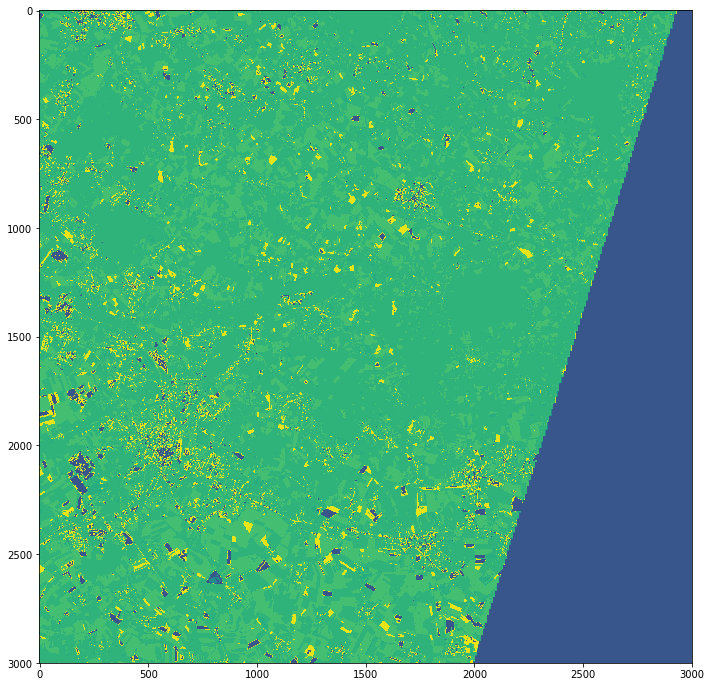

In [47]:
from rasterio import plot
import matplotlib
%matplotlib inline
from matplotlib import pyplot
fig, ax = pyplot.subplots(1, figsize=(12, 12))
plot.show(out,ax=ax)

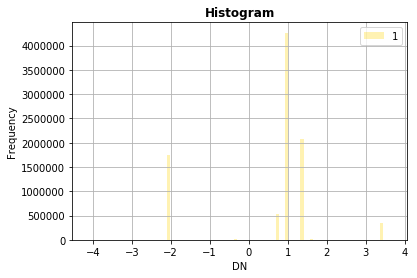

In [51]:
from rasterio.plot import show_hist
show_hist(out, bins=100, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")